In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gekko import GEKKO

from scipy.signal import savgol_filter

In [2]:
czantoria_full = pd.read_csv('data/csv/czantoria_sauce.csv')
czantoria_full.columns = ['time', 'distance', 'heartrate', 'cadence', 'velocity_smooth', 'altitude', 'grade_smooth']
czantoria_nonzero = czantoria_full[(czantoria_full['velocity_smooth'] > 0) | (czantoria_full['time'] == 0)]
czantoria_time = czantoria_nonzero.groupby('distance').agg({'time': 'max'}).reset_index()['time']
czantoria_final = pd.merge(czantoria_nonzero, czantoria_time, on=['time'])

In [3]:
distance_data = czantoria_final['distance'].to_numpy()
grade_data = czantoria_final['grade_smooth'].to_numpy()
elevation_data = czantoria_final['altitude'].to_numpy()

In [4]:
grade_smooth = savgol_filter(grade_data, 501, 1)

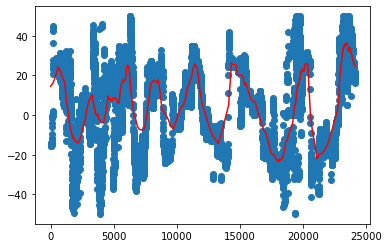

In [5]:
plt.scatter(distance_data, grade_data)
plt.plot(distance_data, grade_smooth, 'r')

In [6]:
# grade_data = np.arctan(grade_data/100)
# yhat = np.arctan(grade_smooth/100)
# plt.scatter(distance_data, grade_data)
# plt.plot(distance_data, yhat, 'r')

In [7]:
grade_data = grade_smooth

print(len(grade_data))

n = distance_data.shape[0]
to_stay = np.zeros(n)
to_stay[0] = 1

for i in range(n - 1):
    if np.abs(grade_data[i+1] - grade_data[i]) < 1.5:
        grade_data[i+1] = grade_data[i]
        to_stay[i+1] = 0
    elif np.sign(grade_data[i+1]) != np.sign(grade_data[i]):
        to_stay[i + 1] = 1
    else:
        to_stay[i + 1] = 1
        
to_stay[-1] = 1

grade_data = grade_data[to_stay == 1]
distance_data = distance_data[to_stay == 1]
elevation_data = elevation_data[to_stay == 1]

print(len(grade_data))

grade_data = np.arctan(grade_data/100)

13385
335


In [8]:
distance = distance_data[-1]

x_data = distance_data/(distance_data[-1])
slope_data = grade_data

# x_data = x_data[x_data <= distance]
# slope_data = slope_data[x_data <= distance]

In [9]:
# create GEKKO model
m = GEKKO()

In [10]:
t_est = 4 * 60 * 60
t_min = 1 * 60 * 60
t_max = 20 * 60 * 60

In [11]:
# constants
N_m = 0.0222
E0 = 1400
X = distance
tau = 0.67
g = 9.81
k = 0.03734
mass = 55
S = 22

In [12]:
# equation parts
alpha = (np.sqrt(S/tau) * X)/E0
beta = (4 * 4184 * 1/75 * N_m * X)/(E0 * np.sqrt(S * tau))
gamma = X/np.sqrt(S * tau**3)
delta = (g*X)/(S*tau)
mu = (k*N_m*X)/(np.sqrt(S*tau))

In [13]:
# scales
u_scale = np.sqrt(S/tau)
v_scale = np.sqrt(S*tau)
t_scale = X/v_scale

In [14]:
# scaled values
sigma0 = 1
e0 = 1
x0 = 0
v0 = 0
n0 = 0.00201818/N_m

e_crit = 0.15 * e0

In [15]:
# sigma data to create spline
# E_data = np.linspace(0, e0, 1001)
# sigma_data = sigma0 * E_data/(e0 * e_crit) + 0.75 * sigma0 * (1 - E_data/(e0 * e_crit))
# sigma_data[E_data > e_crit] = sigma0

# slope data to create spline
# x_data = np.linspace(0, 1, 3000)
# slope_data = np.array(600*[1/18 * np.pi] + 600 * [-1/18 * np.pi] + 600*[1/36 * np.pi] + 600 * [-1/36 * np.pi] + 600 * [1/9 * np.pi])

In [16]:
# time points [s]
nt = 201
tm = np.linspace(0,1,nt)
m.time = tm

In [17]:
# Variables
v = m.Var(value=0.0, lb=0.0, ub=6/v_scale) #velocity
E = m.Var(value=e0, lb=0.0, ub=e0) #energy
x = m.Var(value=0.0) #horizontal coordinate
N = m.Var(value=n0, lb=0.0) # oxidation rate

sigma = m.Const(value=sigma0) #breathing rate
slope = m.Var(value=slope_data[0]) #slope

p = np.zeros(nt)
p[-1] = 1.0
final = m.Param(value=p)

In [18]:
# FV - final time
# tf = m.FV(value=t_est/t_scale,lb=t_min/t_scale,ub=t_max/t_scale)
tf = m.FV(value=t_est/t_scale, lb = 0.1)
tf.STATUS = 1

In [19]:
# MV
u = m.MV(value=0,lb=0,ub=9.6/u_scale)
u.STATUS = 1

In [20]:
# energy decrease at the end
# m.cspline(E, sigma, E_data, sigma_data, True)

# slope
m.cspline(x, slope, x_data, slope_data, True)

In [21]:
# equations
m.Equation(E.dt()==(alpha * (sigma - u * v) + beta * N)*tf)
m.Equation(v.dt()==(gamma * (u - v) - delta * m.sin(slope)) * tf)
m.Equation(x.dt()==(v*m.cos(slope))*tf)
m.Equation(N.dt()==(mu * N * (1 - N))*tf)
m.Equation(alpha * (sigma - u * v) + beta * N <= 0)
m.Equation((distance - X*x)*final<=0)

m.fix_final(E, 0)

In [22]:
m.options.IMODE = 6
m.options.MAX_ITER=30000
m.options.SOLVER=3
# m.options.RTOL=1e-4
# m.options.OTOL=1e-4

m.solve()

print('Final Time: ' + str(tf.value[0] * t_scale))

tm = tm * tf.value[0] * t_scale

apm 80.253.213.10_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            1
   Constants    :            1
   Variables    :           10
   Intermediates:            0
   Connections  :            4
   Equations    :            6
   Residuals    :            6
 
 Number of state variables:           3199
 Number of total equations: -         3000
 Number of slack variables: -          400
 ---------------------------------------
 Degrees of freedom       :           -201
 
 * Warning: DOF <= 0
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This 

  86r 5.1958683e-02 1.91e+04 2.16e+07   2.0 1.20e-01   4.4 1.00e+00 2.40e-01f  1
  87r 5.2070640e-02 1.90e+04 7.27e+05   1.5 1.59e-01   3.9 1.00e+00 1.00e+00f  1
  88r 5.2071827e-02 1.90e+04 1.71e+07   2.1 1.01e-01   6.2 1.00e+00 3.93e-01f  1
  89r 5.2072827e-02 1.90e+04 1.99e+06   2.0 1.09e-01   6.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r 5.2072847e-02 1.90e+04 4.02e+06   1.7 3.30e-02   7.9 1.00e+00 1.00e+00h  1
  91r 5.2072967e-02 1.90e+04 7.38e+06   2.3 1.19e-01   7.5 2.80e-01 4.44e-01F  1
  92r 5.2072969e-02 1.90e+04 1.72e+07   1.9 9.67e-01   7.9 2.43e-02 6.19e-02f  2
  93r 5.2072989e-02 1.90e+04 1.34e+07   1.9 1.52e-01   7.4 6.31e-02 1.97e-01h  1
  94r 5.2072989e-02 1.90e+04 1.33e+07   1.9 1.29e-01   8.7 3.21e-01 3.03e-03h  1
  95r 5.2072990e-02 1.90e+04 2.18e+08   1.9 1.58e-01   9.2 1.00e+00 2.67e-01h  1
  96r 5.2072991e-02 1.90e+04 1.67e+08   2.8 1.63e-01   9.6 1.00e+00 9.14e-02f  2
  97r 5.2072995e-02 1.90e+04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  2.4212900e+01 4.99e+03 8.54e+06   2.6 7.72e+03  -1.5 4.87e-04 5.37e-04h  1
 181  2.4216001e+01 4.94e+03 8.87e+06   2.6 2.39e+03  -1.0 7.89e-03 1.01e-02f  1
 182  2.4216001e+01 4.91e+03 9.18e+06  -3.7 3.58e+03  -1.5 2.93e-04 5.63e-03h  1
 183  2.4217231e+01 4.90e+03 9.15e+06   2.6 4.35e+03  -1.1 2.40e-02 3.56e-03f  1
 184  2.4217231e+01 4.90e+03 9.15e+06  -3.7 1.79e+03  -1.6 8.76e-03 2.99e-04h  1
 185  2.4217254e+01 4.89e+03 9.13e+06   1.0 1.96e+03  -1.1 1.19e-02 1.92e-03h  1
 186  2.4217996e+01 4.87e+03 9.09e+06   1.8 7.07e+03  -1.6 6.51e-03 3.87e-03h  1
 187  2.4219408e+01 4.85e+03 9.05e+06   2.6 4.21e+03  -1.2 3.11e-03 3.23e-03f  1
 188  2.4219408e+01 4.85e+03 9.04e+06  -3.7 3.57e+04  -1.7 2.22e-04 1.19e-03h  1
 189  2.4235241e+01 4.84e+03 9.02e+06   1.9 1.14e+04    -  9.11e-03 2.04e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  2.4283708e+01 4.83e+03

 305r 2.4306499e+01 4.49e+03 1.15e+03  -3.4 8.30e-03   5.2 1.00e+00 3.41e-01f  1
 306r 2.4306499e+01 4.49e+03 1.17e+03  -1.9 3.15e-03   5.6 1.00e+00 4.47e-01f  1
 307r 2.4306499e+01 4.49e+03 1.18e+03  -3.1 9.49e-03   5.1 1.00e+00 1.74e-01f  1
 308r 2.4306499e+01 4.49e+03 1.19e+03  -2.8 3.56e-03   5.5 1.00e+00 3.07e-01f  1
 309r 2.4306499e+01 4.49e+03 1.19e+03  -3.9 1.08e-02   5.1 1.00e+00 1.62e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310r 2.4306499e+01 4.49e+03 1.20e+03  -2.1 4.00e-03   5.5 1.00e+00 3.33e-01f  1
 311r 2.4306499e+01 4.49e+03 1.20e+03  -3.2 1.57e-02   5.0 1.00e+00 9.50e-02f  1
 312r 2.4306499e+01 4.49e+03 1.21e+03  -4.3 4.64e-03   5.4 1.00e+00 3.76e-01f  1
 313r 2.4306499e+01 4.49e+03 1.21e+03  -4.6 1.73e-02   5.0 1.00e+00 6.76e-02f  1
 314r 2.4306499e+01 4.49e+03 1.21e+03  -4.6 5.15e-03   5.4 1.00e+00 2.18e-01f  1
 315r 2.4306499e+01 4.49e+03 1.22e+03  -4.7 1.93e-03   5.8 1.00e+00 3.48e-01f  1
 316r 2.4306499e+01 4.49e+03

 443r 2.4306503e+01 4.46e+03 2.25e+03  -0.2 6.57e-03   5.2 1.00e+00 1.00e+00f  1
 444r 2.4306503e+01 4.46e+03 5.13e+03  -0.4 7.10e-03   5.7 1.00e+00 5.30e-01f  1
 445r 2.4306503e+01 4.46e+03 2.20e+03  -1.0 1.15e-03   6.1 1.00e+00 1.00e+00f  1
 446r 2.4306503e+01 4.46e+03 1.13e+03  -1.9 2.79e-03   5.6 1.00e+00 5.39e-01f  1
 447r 2.4306503e+01 4.46e+03 1.14e+03  -0.2 8.33e-03   5.1 9.69e-01 4.00e-01f  1
 448r 2.4306503e+01 4.46e+03 1.14e+03  -1.4 3.12e-03   5.6 1.00e+00 4.71e-01f  1
 449r 2.4306503e+01 4.46e+03 1.14e+03  -1.5 9.40e-03   5.1 1.00e+00 2.34e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450r 2.4306503e+01 4.46e+03 1.15e+03  -2.5 3.53e-03   5.5 1.00e+00 5.44e-01f  1
 451r 2.4306503e+01 4.46e+03 1.15e+03  -1.6 1.06e-02   5.0 1.00e+00 1.66e-01f  1
 452r 2.4306503e+01 4.46e+03 1.15e+03  -2.3 3.97e-03   5.5 1.00e+00 3.83e-01f  1
 453r 2.4306503e+01 4.46e+03 1.15e+03  -7.6 1.49e-03   5.9 6.56e-01 3.24e-01f  1
 454r 2.4306503e+01 4.46e+03

 541  5.9366006e+01 1.37e+03 3.53e+05   2.6 7.88e+03    -  1.99e-01 3.73e-02f  1
 542  8.8766192e+01 1.27e+03 2.33e+05   2.6 9.62e+03    -  1.25e-01 6.99e-02f  1
 543  9.1184670e+01 1.26e+03 3.45e+05   2.6 1.08e+04    -  1.95e-03 5.14e-03f  1
 544  9.7427826e+01 1.25e+03 5.93e+05   2.6 1.08e+04    -  5.91e-03 1.33e-02f  1
 545  2.2376121e+02 9.14e+02 4.80e+06   2.6 1.08e+04    -  3.80e-03 2.67e-01f  1
 546  2.2547766e+02 9.08e+02 4.76e+06   2.3 5.93e+03    -  1.08e-01 6.64e-03h  1
 547  2.2671666e+02 9.04e+02 4.74e+06   2.3 6.60e+03    -  7.32e-03 4.31e-03h  1
 548  2.4965979e+02 8.32e+02 4.73e+06   2.3 6.64e+03    -  7.13e-04 7.92e-02h  1
 549  2.4992610e+02 8.28e+02 4.56e+06   1.6 6.25e+03    -  2.71e-03 4.66e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 550  2.4992610e+02 8.24e+02 4.71e+06   1.6 1.73e+03  -0.7 7.57e-03 4.57e-03h  1
 551  2.4992611e+02 8.07e+02 4.29e+06   1.6 2.63e+03  -0.3 3.46e-03 2.13e-02h  3
 552  2.4992612e+02 8.06e+02

 637  5.7535271e-04 3.45e-02 9.46e-03  -7.6 1.30e+00    -  1.00e+00 1.00e+00h  1
 638  5.6775339e-04 2.20e-02 8.79e-03  -7.8 1.16e+00    -  1.00e+00 1.00e+00h  1
 639  5.6261780e-04 4.33e-03 2.55e-03  -8.1 1.39e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 640  5.5946074e-04 8.63e-04 1.34e-03  -8.5 5.44e-01    -  1.00e+00 1.00e+00h  1
 641  5.6108076e-04 8.10e-04 1.76e-04  -8.3 6.07e-01    -  1.00e+00 1.00e+00h  1
 642  5.5916047e-04 6.27e-04 6.01e-04  -8.6 2.19e-01    -  1.00e+00 1.00e+00h  1
 643  5.5992979e-04 9.03e-03 1.70e-01  -8.4 2.65e+00    -  1.00e+00 5.63e-01h  1
 644  5.5979615e-04 4.37e-03 1.22e-02  -8.5 1.19e+00    -  9.41e-01 1.00e+00h  1
 645  5.5978886e-04 7.96e-04 7.54e-07  -8.5 5.70e-01    -  1.00e+00 1.00e+00h  1
 646  5.5978813e-04 3.45e-05 2.66e-08  -8.5 6.89e-02    -  1.00e+00 1.00e+00h  1
 647  5.5815753e-04 1.63e-02 2.35e-01  -9.0 2.00e+00    -  5.01e-01 1.00e+00h  1
 648  5.5822902e-04 1.46e-02

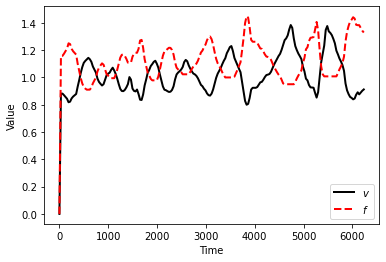

In [23]:
plt.figure(1)
plt.plot(tm,v.value,'k-',lw=2,label=r'$v$')
plt.plot(tm,u.value,'r--',lw=2,label=r'$f$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

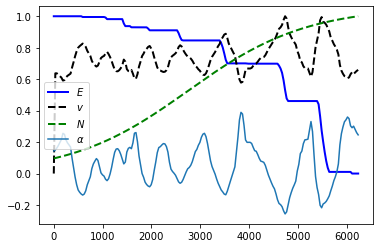

In [24]:
plt.figure(2)
plt.plot(tm,np.array(E.value)/max(E.value),'b-',lw=2,label=r'$E$')
plt.plot(tm,np.array(v.value)/max(v.value),'k--',lw=2,label=r'$v$')
# plt.plot(tm, np.array(sigma.value)/max(sigma.value), 'y-', lw=2, label=r'$\sigma$')
plt.plot(tm, np.array(N.value)/max(N.value), 'g--', lw=2, label=r'$N$')
plt.plot(tm,slope, label=r'$\alpha$')
plt.legend()
plt.show()

In [25]:
6281/3600

1.7447222222222223

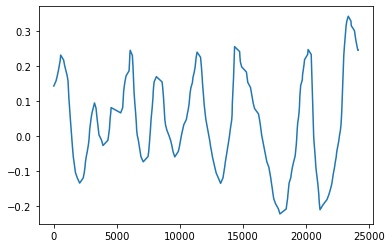

In [26]:
plt.plot(distance_data, grade_data)